# Rapport du projet de résolution de problème

- Paul Achard
- Julien Faure

    
- *Date : 20/01/2022*

---

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Problématique

Notre problématique est d'identifier un chiffre à partir d'une image.
Plus spécifiquement, une image de 8x8 pixels en niveau de gris.

## Objectifs

- Trouver un modèle permettant d'identifier un chiffre à partir d'une image
- Comparer les différents modèles ainsi que leur hyper paramètres

## Analyse du dataset

Identifier un chiffre à partir d'une image est une tache qui peut s'avérer très complexe. Afin d'avoir une difficulté raisonnable et adapté au contexte de ce projet, nous avons fixé certains paramètres dans notre dataset.

- La résolution de nos images est identique pour tout le dataset. Cette résolution est **8 pixels par 8 pixels**.
- Chaque pixel est codé sur **4 bits**.
- Les images contiennent uniquement un chiffre sans élément parasite, sans effet et sans traitement.

Nous utilisons le dataset `digits` de `sklearn`.

### Forme du dataset

In [46]:
# Import du dataset
digits = datasets.load_digits()

# Affiche le nombre d'images et leur format
print("Image Data Shape" , digits.data.shape)

# Affiche le nombre de labels
print("Label Data Shape", digits.target.shape)

Image Data Shape (1797, 64)
Label Data Shape (1797,)


Comme nous pouvons le voir ci-dessus, le dataset est composé de **1797** images labellisées.

### Répartition des images du dataset

[Text(0.5, 0, 'n° labellisé'), Text(0, 0.5, 'Occurrence')]

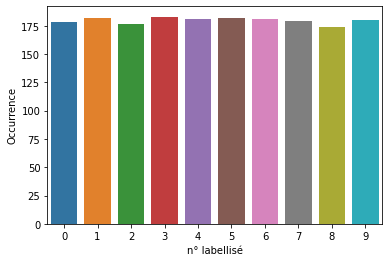

In [47]:
graphique = sns.countplot(x=digits.target)
graphique.set(xlabel="n° labellisé", ylabel = "Occurrence")

Les données labellisées sont équitablement distribuées (environ 175 par label).

### Représentation des données

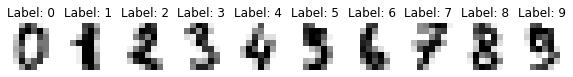

In [48]:
# Création de 10 figures de 10 par 3 pixels
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 3))

# Pour chaque figure, on affiche l'image du chiffre et son label en titre
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title("Label: %i" % label)

### Représentation des images

In [49]:
# Affiche le tableau représentant la première image
print(digits.images[0])
print("\n Type de chaque valeur :", type(digits.images[0][0][0]))

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]

 Type de chaque valeur : <class 'numpy.float64'>


> Comme nous l'avons vu précédemment, chaque image possède une résolution de 8x8 pixels en niveaux de gris codés sur 4bits par pixel.

Dans notre programme, une image est représentée par une matrice de dimension 8x8. Chaque élément représente un pixel avec un niveau de gris codé sur 4bits (de 0 à 15). Plus la valeur est élevée, plus la couleur est foncée.

> Exemple :
* 0 : Blanc
* 15 : Noir

### Mise en forme des données d'entrées

Pour commencer, nous devons redimenssionner nos données d'entrées.

Actuellement, nous avons des données sous la forme d'un tableau de matrice.

Il nous faut les mettre sous forme d'une matrice où chaque vecteur correspond aux pixels de l'image.

Donc si nous avons 1797 images, la matrice d'entrée est composée de 1797 vecteurs.

Avec une résolution de 8x8, la taille d'un vecteur est de 64 valeurs.

In [50]:
# Redimensionne la matrice en vecteur
print(digits.images[0].reshape(-1))

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [51]:
# Redimenssionne le tableau de matrice en matrice
x = digits.images.reshape((len(digits.images), -1))
y = digits.target

## Préparation des données

### Jeu de test et jeu d'entraînement

Il nous faut maintenant séparer notre jeu de test et notre jeu d'entraînement du dataset.

Pour choisir la taille de notre jeu de test, il est nécessaire de faire attention à plusieurs points :
* Le temps d'entrainement de notre modèle
* La taille de notre dataset

Plus la proportion du jeu d'entraînement est faible, plus notre modèle à un niveau de variance élevé. Ainsi, on augmente les chances d'avoir de l'*over fitting*.

A contrario, plus la proportion du jeu de test est faible, plus notre modèle à un niveau de variance faible. Ainsi, on augmente les chances d'avoir de l'*under fitting*.

Le but est donc de trouver la valeur qui nous permet d'avoir le taux de variance optimal.


Pour trouver cette valeur, nous avons appliqué la procédure suivante, nous avons essayé avec plusieurs valeurs en partant de 20% jusqu'à 80% avec un pas de 5%. Nous avons déterminé que la meilleure valeur est **35%**.


> [https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio](https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio)

In [52]:
# séparation du dataset en données "d'apprentissage" et de test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=0)

### Création du tableau de résultat

In [53]:
Evaluation_Results = pd.DataFrame(np.zeros((6, 1)), columns=['Best Mean Test Score'])
Evaluation_Results.index = ['Logistic Regression (LR)', 'Naïve Bayes Classifier (NB)',
                            'Decision Tree Classifier (DT)', 'Gradient Boosting (GB)',
                            'Support Vector Machines (SVM)', 'K Nearest Neighbours (KNN)']
Evaluation_Results

,Best Mean Test Score
Logistic Regression (LR),0.0
Naïve Bayes Classifier (NB),0.0
Decision Tree Classifier (DT),0.0
Gradient Boosting (GB),0.0
Support Vector Machines (SVM),0.0
K Nearest Neighbours (KNN),0.0


## Test de différents modèles

Pour résoudre notre problème, nous allons essayer les modèles suivants :
* Modèle de regréssion logistique multiclasse
* CLassification naïve bayésienne
* Classification par abre de décision
* Classification par boosting de gradient
* Classification par machine à vecteurs de support
* Classification par voisin le plus proche


### Modèle de regréssion logistique multiclasse

In [54]:
# Création du modèle de régression
LR_model = LogisticRegression(verbose=False, max_iter=10000)

# Dictionnaire contenant les différents paramètres à essayer
LR_params = dict()
LR_params['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
LR_params['penalty'] = ['l2', 'none']
LR_params['C'] = [0.1, 5, 10]

# Création de nos itérations
kFold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# Création de notre modèle de validation croisée
model_cv = GridSearchCV(estimator=LR_model,
                        param_grid=LR_params,
                        scoring='accuracy',
                        cv=kFold,
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True)

# Entrainement du modèle
model_cv.fit(x_train, y_train)
# cv results
pd.set_option('display.max_columns', None)
cv_results = pd.DataFrame(model_cv.cv_results_)

# Stockage du meilleur résultat dans le tableau des résultats
Evaluation_Results.iloc[0]['Best Mean Test Score'] = max(cv_results['mean_test_score'])

cv_results

Fitting 15 folds for each of 18 candidates, totalling 270 fits


c:\users\paula\desktop\mines\machine_learning\mines-ai-number-recognition-project\venv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\paula\desktop\mines\machine_learning\mines-ai-number-recognition-project\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\paula\desktop\mines\machine_learning\mines-ai-number-recognition-project\venv\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _chec

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,split12_train_score,split13_train_score,split14_train_score,mean_train_score,std_train_score
0,0.629559,0.074395,0.001217,0.002744,0.1,l2,newton-cg,"{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-...",0.978632,0.965812,0.974359,0.982833,0.969957,0.974359,0.987179,0.970085,0.957082,0.982833,0.970085,0.961538,0.982906,0.969957,0.957082,0.972313,0.009115,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,2.144651,0.964299,0.000537,0.002011,0.1,l2,lbfgs,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.978632,0.965812,0.974359,0.982833,0.969957,0.974359,0.987179,0.970085,0.957082,0.982833,0.970085,0.961538,0.982906,0.969957,0.957082,0.972313,0.009115,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.053008,0.003526,0.000412,0.000825,0.1,l2,liblinear,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.978632,0.965812,0.961538,0.969957,0.952790,0.957265,0.982906,0.952991,0.948498,0.982833,0.952991,0.961538,0.974359,0.961373,0.969957,0.964896,0.010858,10,0.994647,0.998929,0.994647,0.995722,0.996791,0.992505,0.996788,0.995717,0.995722,0.996791,0.995717,0.996788,0.995717,0.996791,0.996791,0.996004,0.001381
3,0.127398,0.004972,0.000000,0.000000,0.1,none,newton-cg,"{'C': 0.1, 'penalty': 'none', 'solver': 'newto...",0.970085,0.957265,0.965812,0.974249,0.961373,0.978632,0.982906,0.974359,0.957082,0.974249,0.965812,0.965812,0.978632,0.957082,0.935622,0.966598,0.011553,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.048062,0.006584,0.001080,0.002754,0.1,none,lbfgs,"{'C': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}",0.957265,0.948718,0.965812,0.944206,0.948498,0.970085,0.970085,0.965812,0.922747,0.969957,0.948718,0.957265,0.965812,0.957082,0.939914,0.955465,0.013029,13,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,0.000816,0.002066,0.000000,0.000000,0.1,none,liblinear,"{'C': 0.1, 'penalty': 'none', 'solver': 'libli...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.716656,0.088624,0.000533,0.001360,5,l2,newton-cg,"{'C': 5, 'penalty': 'l2', 'solver': 'newton-cg'}",0.978632,0.970085,0.965812,0.974249,0.965665,0.974359,0.978632,0.965812,0.965665,0.987124,0.957265,0.957265,0.982906,0.965665,0.948498,0.969176,0.010046,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,2.704039,1.516779,0.000539,0.002018,5,l2,lbfgs,"{'C': 5, 'penalty': 'l2', 'solver': 'lbfgs'}",0.978632,0.970085,0.965812,0.974249,0.969957,0.974359,0.978632,0.965812,0.965665,0.987124,0.957265,0.957265,0.982906,0.965665,0.948498,0.969462,0.010003,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,0.094637,0.006317,0.000955,0.002077,5,l2,liblinear,"{'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}",0.970085,0.965812

La validation croisée nous permet de determiner les paramètres optimaux pour notre modèle d'apprentissage.
Les résultats de nos tests avec de nombreux paramètres différents (dont la plupart ne sont pas présent dans l'exemple ci-dessus).
* Le **paramètre C** correspond à l'inverse de la force de régularisation des données. Plus ce paramètre est grand, plus le risque d'overfitting est grand. Une valeur de 0.1 semble être optimale.
* Le **paramètre de pénalité** permet de réduire les coefficients θ. On remarque une perte de précision si l'on n'applique pas de pénalité. La meilleure pénalité semble être la norme L2.
* Le **solveur** correspond à l'algorithme d'optimisation utilisé pour l'entrainement. Dans notre cas, lbfgs permet d'obtenir la precision la plus élevée malgré un temps d'entrainement significativement plus long que ses concurrents.

### Classification naïve bayésienne


In [55]:
NB_model = BernoulliNB()

NB_params = {'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]}
kFold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(NB_model, NB_params, n_iter=7, scoring='accuracy', n_jobs=-1, cv=kFold, random_state=1)

RCV.fit(x_train, y_train)
cv_results = pd.DataFrame(RCV.cv_results_)

# Stockage du meilleur résultat dans le tableau des résultats
Evaluation_Results.iloc[1]['Best Mean Test Score'] = max(cv_results['mean_test_score'])

cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002513,0.005388,0.000428,0.001602,0,{'alpha': 0},0.837607,0.871795,0.854701,0.836910,0.845494,0.871795,0.850427,0.854701,0.819742,0.875536,0.833333,0.854701,0.858974,0.866953,0.871245,0.853594,0.015985,7
1,0.008271,0.011004,0.002058,0.004222,0.0001,{'alpha': 0.0001},0.841880,0.884615,0.854701,0.849785,0.854077,0.876068,0.880342,0.863248,0.828326,0.879828,0.854701,0.858974,0.867521,0.871245,0.884120,0.863296,0.015941,4
2,0.004065,0.007621,0.001352,0.003105,0.001,{'alpha': 0.001},0.846154,0.884615,0.854701,0.849785,0.858369,0.876068,0.884615,0.867521,0.836910,0.875536,0.854701,0.858974,0.867521,0.871245,0.884120,0.864722,0.014346,1
3,0.005410,0.007391,0.001961,0.005265,0.01,{'alpha': 0.01},0.850427,0.884615,0.854701,0.849785,0.858369,0.867521,0.876068,0.867521,0.841202,0.875536,0.858974,0.858974,0.863248,0.871245,0.884120,0.864154,0.012277,3
4,0.003923,0.004079,0.000274,0.000698,0.1,{'alpha': 0.1},0.854701,0.880342,0.854701,0.849785,0.858369,0.863248,0.871795,0.867521,0.841202,0.884120,0.867521,0.858974,0.854701,0.871245,0.888412,0.864442,0.012759,2
5,0.004051,0.004113,0.000816,0.002065,0.5,{'alpha': 0.5},0.850427,0.876068,0.850427,0.845494,0.845494,0.858974,0.867521,0.867521,0.836910,0.884120,0.871795,0.850427,0.854701,0.854077,0.875536,0.859300,0.013215,5
6,0.003044,0.003899,0.001574,0.003172,1.0,{'alpha': 1.0},0.850427,0.871795,0.850427,0.841202,0.845494,0.858974,0.867521,0.867521,0.832618,0.879828,0.871795,0.841880,0.854701,0.854077,0.875536,0.857587,0.013731,6


Le seul paramètre testé dans ce modèle, alpha, correspond à la force du lissage de Laplace à appliquer au modèle.
En d'autres termes, ce paramètre permet de palier la présence d'une caractéristique dans le jeu de test qui n'existe pas dans le jeu d'entrainement.
> https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece

Au vu des résultats, le paramètre alpha semble être optimal autour de 0.001


### Classification par arbre de décision

In [56]:
DT_model = DecisionTreeClassifier()

DT_params = dict()
DT_params['max_depth'] = [3, None]
DT_params['min_samples_leaf'] = [1, 2, 3, 4]
DT_params['criterion'] = ["gini", "entropy"]
DT_params['splitter'] = ["best", "random"]

kFold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
RCV = RandomizedSearchCV(DT_model, DT_params, n_iter=32, scoring='accuracy', n_jobs=-1, cv=kFold, random_state=1)

DT = RCV.fit(x_train, y_train)
cv_results = pd.DataFrame(DT.cv_results_)

# Stockage du meilleur résultat dans le tableau des résultats
Evaluation_Results.iloc[2]['Best Mean Test Score'] = max(cv_results['mean_test_score'])

cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008339,0.013826,0.002086,0.005318,best,1,3,gini,"{'splitter': 'best', 'min_samples_leaf': 1, 'm...",0.410256,0.470085,0.410256,0.484979,0.463519,0.423077,0.457265,0.457265,0.472103,0.467811,0.423077,0.452991,0.465812,0.493562,0.446352,0.453227,0.024958,30
1,0.005206,0.007362,0.000000,0.000000,random,1,3,gini,"{'splitter': 'random', 'min_samples_leaf': 1, ...",0.414530,0.547009,0.517094,0.553648,0.484979,0.495726,0.452991,0.482906,0.476395,0.536481,0.448718,0.427350,0.504274,0.497854,0.437768,0.485182,0.041496,27
2,0.005644,0.009215,0.000000,0.000000,best,2,3,gini,"{'splitter': 'best', 'min_samples_leaf': 2, 'm...",0.410256,0.470085,0.410256,0.484979,0.463519,0.423077,0.457265,0.457265,0.472103,0.472103,0.423077,0.452991,0.465812,0.493562,0.446352,0.453514,0.025147,29
3,0.004432,0.006140,0.001480,0.004123,random,2,3,gini,"{'splitter': 'random', 'min_samples_leaf': 2, ...",0.461538,0.525641,0.564103,0.605150,0.472103,0.487179,0.478632,0.508547,0.489270,0.459227,0.431624,0.448718,0.461538,0.519313,0.553648,0.497749,0.046556,25
4,0.007297,0.011226,0.000000,0.000000,best,3,3,gini,"{'splitter': 'best', 'min_samples_leaf': 3, 'm...",0.410256,0.470085,0.410256,0.484979,0.463519,0.423077,0.457265,0.457265,0.472103,0.467811,0.423077,0.452991,0.465812,0.493562,0.446352,0.453227,0.024958,30
5,0.002085,0.005316,0.001041,0.003897,random,3,3,gini,"{'splitter': 'random', 'min_samples_leaf': 3, ...",0.491453,0.491453,0.448718,0.480687,0.557940,0.551282,0.414530,0.474359,0.407725,0.463519,0.495726,0.504274,0.465812,0.467811,0.407725,0.474868,0.043379,28
6,0.007728,0.007554,0.000000,0.000000,best,4,3,gini,"{'splitter': 'best', 'min_samples_leaf': 4, 'm...",0.410256,0.470085,0.410256,0.484979,0.463519,0.423077,0.457265,0.457265,0.472103,0.467811,0.423077,0.452991,0.465812,0.493562,0.442060,0.452941,0.025060,32
7,0.004167,0.006911,0.000000,0.000000,random,4,3,gini,"{'splitter': 'random', 'min_samples_leaf': 4, ...",0.440171,0.487179,0.440171,0.502146,0.390558,0.576923,0.482906,0.512821,0.493562,0.467811,0.482906,0.474359,0.585470,0.575107,0.527897,0.495999,0.052403,26
8,0.016113,0.004584,0.000135,0.000506,best,1,None,gini,"{'splitter': 'best', 'min_samples_leaf': 1, 'm...",0.807692,0.816239,0.846154,0.811159,0.811159,0.846154,0.841880,0.807692,0.785408,0.781116,0.773504,0.829060,0.858974,0.858369,0.798283,0.818190,0.026691,4
9,0.005791,0.005648,0.000672,0.002035,random,1,None,gini,"{'splitter': 'random', 'min_samples_leaf': 1, ...",0.769231,0.867521,0.837607,0.836910,0.832618,0.871795,0.777778,0.799145,0.832618,0.789700,0.794872,0.824786,0.816239,0.781116,0.815451,0.816492,0.030095,5


Les paramètres testés pour ce modèle sont :
* le max_depth, correspondant à la profondeur de l'arbre qui doit être illimité pour garantir une précision maximale du modèle.
* le min_samples_leaf, correspondant au nombre d'échantillons minimal par feuille qui doit être de 1.
* le criterion est une fonction permettant de mesurer la qualité d'un split, nous obtenons des meilleurs résultats avec 'entropy'.
* le splitter est la méthode choisie pour selectionner le split à chaque noeud. Modifier ce paramètre ne semble pas impacter significativement les résultats.

### Classification par boosting de gradient

In [ ]:
GB_model = GradientBoostingClassifier()
GB_params = dict()
GB_params['n_estimators'] = [100, 200, 500]
GB_params['max_depth'] = [1, 2, 3, 5]
GB_params['learning_rate'] = [0.1, 0.2, 0.3]

kFold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(GB_model, GB_params, n_iter=36, scoring='accuracy', n_jobs=-1, cv=kFold, random_state=1)

GB = RCV.fit(x_train, y_train)
cv_results = pd.DataFrame(GB.cv_results_)

# Stockage du meilleur résultat dans le tableau des résultats
Evaluation_Results.iloc[3]['Best Mean Test Score'] = max(cv_results['mean_test_score'])

cv_results

Pour améliorer la précision de notre modèle, nous pouvons faire varrier les trois paramètes suivants :
* Le nombre d'estimation
* La profondeur maximale
* Le taux d'apprentissage

#### Le nombre d'estimation

Ce paramètre permet de jouer sur le nombre d'arbre du modèle.
Plus ce paramètre est élevé, plus le modèle est précis.

Néanmoins, une valeur trop élevé peut causer des problèmes de performance lors de l'apprentissage.

#### La profondeur maximale

Cette valeur définit la profondeur des arbres utilisé.

Il est important de choisir une profondeur adaptée à notre jeu d'entrainement au risque de faire de l'`over fitting`.

#### Le taux d'apprentissage

Il permet d'éviter l'`under fitting` et l'`over fitting`.
Un taux d'apprentissage trop élevé pourrait amener à de l'`over fitting` et donc un mauvais résultat avec le jeu de test.
A l'inverse, un taux d'apprentissage trop faible conduirait à de l'`under fitting`.

---

> Source : [https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae)

---

#### Analyse des résultats


In [ ]:
cv_results[["param_n_estimators","param_max_depth","param_learning_rate","mean_test_score","rank_test_score"]].sort_values("rank_test_score")

Le meilleur résultat semble être avec la configuration suivante :

|  Paramètre  | Valeur  |
|---|---|
| n_estimators |  100 |
| max_depth  | 3  |
|  learning_rate | 0.1  |

> Nous avons essayé d'augmenté *le nombre d'itération* mais cela a un impacte négligeable sur le résultat.

### Classification par machine à vecteurs de support

In [ ]:
from sklearn import svm

SVC_model = svm.SVC()

SVC_params = dict()
SVC_params['gamma'] = [0.01, 0.001, 0.0001]
SVC_params['C'] = [0.1, 0.5, 1, 2]

kFold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(SVC_model, SVC_params, n_iter=50, scoring='accuracy', n_jobs=-1, cv=kFold, random_state=1)

SVC = RCV.fit(x_train, y_train)
cv_results = pd.DataFrame(SVC.cv_results_)

# Stockage du meilleur résultat dans le tableau des résultats
Evaluation_Results.iloc[4]['Best Mean Test Score'] = max(cv_results['mean_test_score'])

cv_results

#### Paramètres

* `gamma` : Permet de définir le niveau de précision du modèle. Le paramètre peut prendre une valeur entre 0 et 1. Plus la valeur est proche de 0, plus le model va s'adapter au jeu d'entrainement ce qui risque de provoquer de l'under fitting. Au contraire, une valeur trop proche de 0, risque de provoquer de l'overfitting.

* `C` : Permet de définir l'importance des mauvaises classifications. Il permet de définir la marge entre deux classes.

#### Analyse des résultats

In [ ]:
cv_results[["param_gamma","param_C","mean_test_score","rank_test_score"]].sort_values("rank_test_score")

La meilleure configuration semble être :

| Paramètre  |  Valeur  |
|---|---|
| Gamma  | 0.001  |
|  C | 1  |

*Sources :*
* [https://www.quora.com/What-is-regularization-parameter-in-SVM](https://www.quora.com/What-is-regularization-parameter-in-SVM)
* [https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python](https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python)
* [https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC)


### Classification par voisin le plus proche

In [ ]:
KNN_model = KNeighborsClassifier()

KNN_params = dict()
KNN_params['n_neighbors'] = [i for i in range(1, 20, 5)]
KNN_params['weights'] = ["uniform", "distance"]
KNN_params['algorithm'] = ["auto", "ball_tree", "kd_tree", "brute"]
KNN_params['leaf_size'] = [1, 10, 30]
KNN_params['p'] = [1, 2]

kFold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(KNN_model, KNN_params, n_iter=50, scoring='accuracy', n_jobs=-1, cv=kFold, random_state=1)

KNN = RCV.fit(x_train, y_train)
cv_results = pd.DataFrame(KNN.cv_results_)

# Stockage du meilleur résultat dans le tableau des résultats
Evaluation_Results.iloc[5]['Best Mean Test Score'] = max(cv_results['mean_test_score'])

cv_results

#### Paramètres

* n_neighbors: Permet de définir le nombre de voisins le plus proche. C'est-à-dire, le nombre de points à prendre dans la décision de classification. Ces points étant au plus proche de l'élément à classifier. C'est généralement un nombre pair.

* weights: Permet de définir le poids de chaque point proches pris en compte dans la decision.
    * uniform : Tous les points ont le même poids
    * distance : Le poids de chaque point est déterminé en fonction de sa distance avec l'élément qu'on essaie de classifier.
* algorithm : C'est l'algorithme utilisé pour trouver les points les plus proches de l'élément qu'on essaie de classifier.
* leaf_size : Permet de définir la taille des feuilles utilisée dans les algorithmes BallTree et KDTree.

#### Analyse des résultats

In [ ]:
cv_results[["param_n_neighbors","param_weights","param_algorithm","param_leaf_size","mean_test_score","rank_test_score"]].sort_values("rank_test_score")

Il semble difficile de déterminer quelle est la meilleure configuration au vu des résultats mais on peut en extraire une certaine tendance.

Le paramètre 'weights' n'a pas beaucoup d'importance.

La différence se fait sur les paramètres algotithm et n_neighbors avec comme valeur pour le premier `kd_tree`/`ball_tree`/`auto` et pour le second 1.

Sources :
* [https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
* [https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn](https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn)
* [https://www.datasklr.com/select-classification-methods/k-nearest-neighbors](https://www.datasklr.com/select-classification-methods/k-nearest-neighbors)


### Comparaison des résultats

In [ ]:
df = pd.DataFrame(Evaluation_Results)
df.plot(kind = 'bar')
plt.show()

Evaluation_Results

Au vu des résultats, le modèle ayant la meilleure exactitude semble être la classification machine à vecteurs de support avec pour paramètre 'gamma' = 0.001 et 'C'= 1.


## Entrainement et test d'un prédicteur

Maintenant que l'on connait le modèle le plus efficace, nous allons créer un predicteur afin de répondre à notre problematique.

In [ ]:
SVC_definitive_model = svm.SVC(gamma=0.001, C=1)

SVC_fitted = SVC_definitive_model.fit(x_train, y_train)

### Matrice de confusion

In [ ]:
from sklearn import metrics
predicted = SVC_fitted.predict(x_test)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted, cmap=plt.cm.gray_r)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

La matrice de confusion nous permet de constater que les rares erreurs sont souvent sur les labels 2, 5.
Une solution envisageable serait d'ajouter plus de données pour les labels 2, 5 pour entrainer le modèle.

### Test du prédicteur avec des données externes

Essayons à présent de tester notre prédicteur sur des images que nous avons créées grâce au logiciel paint.
Les images créées pour le test sont assez différentes des images d'entrainements. En effet, les images d'entrainements ressemblent à des images créées avec une résolution élevée puis "downscalées" contrairement à nos images de test qui ont été réalisées directement en 8x8 pixel. Cette différence est visible au niveau de la plage de niveau de gris qui est plus large sur les images d'entrainement que sur les images de test ou un pixel est blanc ou noir uniquement.

In [ ]:
from PIL import Image, ImageChops

# Import de nos images et inversion des niveaux de gris
image_test_1 = np.array(ImageChops.invert(Image.open('test_images/1.bmp'))) - 240
image_test_2 = np.array(ImageChops.invert(Image.open('test_images/2.bmp'))) - 240
image_test_3 = np.array(ImageChops.invert(Image.open('test_images/3.bmp'))) - 240
image_test_4 = np.array(ImageChops.invert(Image.open('test_images/4.bmp'))) - 240
image_test_5 = np.array(ImageChops.invert(Image.open('test_images/5.bmp'))) - 240
image_test_6 = np.array(ImageChops.invert(Image.open('test_images/6.bmp'))) - 240
image_test_7 = np.array(ImageChops.invert(Image.open('test_images/7.bmp'))) - 240
image_test_8 = np.array(ImageChops.invert(Image.open('test_images/8.bmp'))) - 240
image_test_9 = np.array(ImageChops.invert(Image.open('test_images/9.bmp'))) - 240


images_test = np.array([image_test_1, image_test_2, image_test_3, image_test_4, image_test_5, image_test_6, image_test_7, image_test_8, image_test_9])

# Création de 10 figures de 10 par 3 pixels
_, axes = plt.subplots(nrows=1, ncols=9, figsize=(10, 3))

# prédiction du prédicteur
y_pred = SVC_fitted.predict(images_test.reshape(len(images_test), -1))

# Pour chaque figure, on affiche l'image du chiffre et son label en titre
for ax, image, label in zip(axes, images_test, y_pred):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title("Pred: %i" % label)

Malgré les différences entre le jeu de test créé et le jeu d'entrainement, le prédicteur semble capable de reconnaitre les chiffres présents dans les images la plupart du temps. Cependant, après avoir modifié les images de test et réessayer plusieurs fois le test, on remarque que notre prédicteur à du mal à prédire les chiffres 3 et 6.

# Conclusion

Bien que notre prédicteur puisse atteindre 99% de véridicité sur le dataset initial, une fois confronté à des données rédigées à la main sur le logiciel paint sans anticrénelage, ce dernier semble perdre en efficacité. Cette perte s'explique par la spécificité du dataset initial. Afin de palier cette perte, nous pourrions compléter le dataset en en ajoutant une version dupliquée dans laquelle nous supprimons l'antialiasing.